Coryn Bailer-Jones, MPIA Heidelberg (https://mpia.de/homes/calj)

The main reference for this tutorial is [Cluster distance inference](resources/cluster_inference.pdf)

# Global settings

Relative to the root directory, ensure that the R codes (*.R) are "Rcode/" and the data files (*.csv) are in "data/"

In [1]:
rootDir <- "./" # directory containing Rcode/ and data/ directories

In [2]:
setwd(paste(rootDir, "Rcode", sep=""))
conv <- pi/180 
source("general_functions.R")
source("distance_functions.R")
setwd("../")
library(MASS) # for truehist
library(fields) # for image.plot
library(RColorBrewer) # for colorRampPalette
mypalette <- colorRampPalette(brewer.pal(9, "Greys"), space="rgb", interpolate="linear", bias=2.5)
mycols <- mypalette(64)

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


# Read and check GDR1 data

In [3]:
# parallaxes are in mas, angles in degrees
dat <- read.csv(paste(rootDir, "data/gdr1set03.csv", sep=""), sep=",")
# To prevent hitting numerical limits in the likelihood calculations, retain parallaxes in mas. 
# Thus distances in this notebook are in kpc.
# For testing use a smaller data set
#dat <- dat[1:25,]
# To investigate the impact of larger uncertainties, scale parallax SD:
#dat$parallax_error <- dat$parallax_error*20

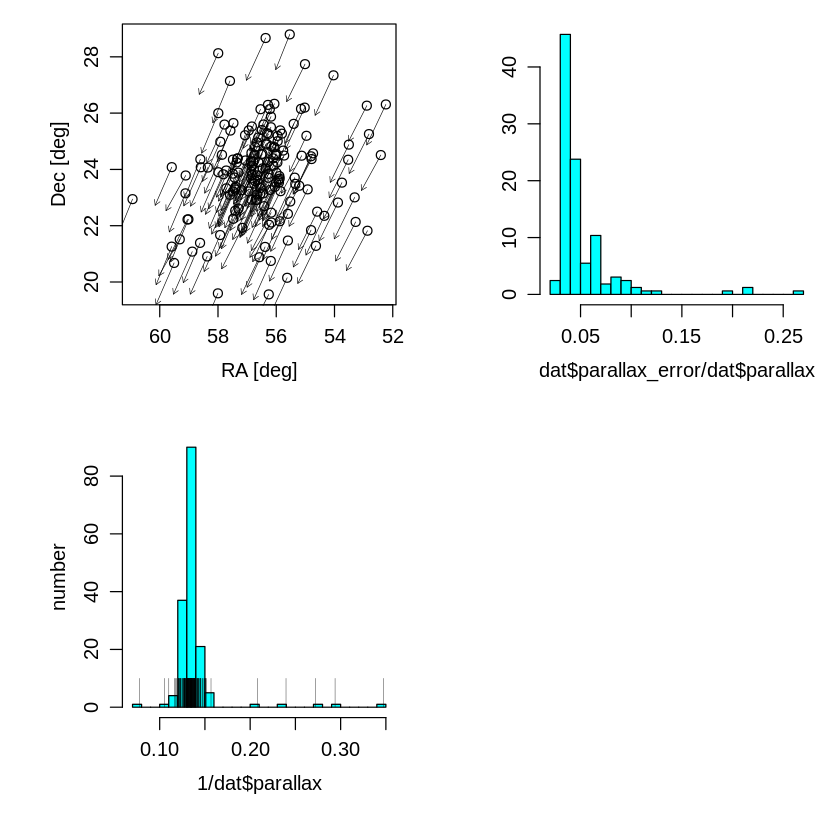

In [4]:
# First inspect the data
par(mfrow=c(2,2), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
# Show source positions on sky along with proper motions
plot(dat$ra, dat$dec, xlim=rev(range(dat$ra)), xlab="RA [deg]", ylab="Dec [deg]")
sf <- 0.03 # scale factor for visualizing PM arrows
arrows(dat$ra, dat$dec, dat$ra+sf*dat$pmra, dat$dec+sf*dat$pmdec, length=0.05, lw=0.5)
# Histogram of fractional parallax uncertainties
truehist(dat$parallax_error/dat$parallax, nbins=25)
# Histogram of inverse parallaxes, for orientation.
truehist(1/dat$parallax, nbins=25, prob=FALSE, ylab="number")
segments(x0=1/dat$parallax, y0=0, x1=1/dat$parallax, y1=10, lw=0.3)

# Naive parallax combination

The following methods for estimating the cluster distance from some combination of the parallaxes and their uncertainties are poor. 

First, it is quite wrong to estimate the cluster distance via the mean of the inverse parallaxes (image some parallaxes were negative), and is meaningless when the fractional uncertainties are large. I do it here for comparison (and it's a fair way of getting a feel for the order-of-magnitude that the data imply).

In [5]:
cat("Mean and SD of inverse parallaxes: ", mean(1/dat$parallax), sd(1/dat$parallax), "kpc\n")
# Note that this is an SD in the sense of a spread, not a standard uncertainty in the mean

Mean and SD of inverse parallaxes:  0.1376619 0.02686311 kpc


The next thing we could think about doing is taking the inverse of the mean of parallaxes, and estimating its variance by a first order Taylor expansion. This is a slight improvement, but still not what we should be doing.

In [6]:
Nstar <- nrow(dat)
mpar  <- mean(dat$parallax)
rNaive1 <- 1/mpar
rNaive1SD <- (1/Nstar)*sqrt(sum(dat$parallax_error^2)) / mpar^2
cat("Inverse of mean parallaxes: ", rNaive1, "+/-", rNaive1SD, "kpc\n")
# This gives an estimate of the distance to the cluster, together with the standard deviation in this mean.
cat("SD of inverse mean parallax in the sense of a spread:", sd(dat$parallax_error)/mpar^2, "kpc\n")

Inverse of mean parallaxes:  0.1347596 +/- 0.0005589137 kpc
SD of inverse mean parallax in the sense of a spread: 0.002887234 kpc


We could go one step further and take a (variance) weighted mean. Specifically, take the inverse of the variance weighted mean of the parallaxes and estimate the variance of this again by a first order Taylor expansion.

In [7]:
wfac <- sum(1/dat$parallax_error^2)
wmpar <- sum(dat$parallax/dat$parallax_error^2)/wfac
rNaive2 <- 1/wmpar
rNaive2SD <- 1/(wmpar^2 * sqrt(wfac))
cat("Inverse of weighted mean of parallaxes: ", rNaive2, "+/-", rNaive2SD, "kpc\n")

Inverse of weighted mean of parallaxes:  0.1337066 +/- 0.000428167 kpc


# Estimate distance to cluster (no correlations or cluster spread)

Rather than mucking about with inverting and averaging the parallaxes, we should think about what we want to achieve. We want to infer the distance, $r$, to the cluster given a set of parallaxes $\{\varpi\}$ and corresponding parallax uncertainties $\{\sigma_{\varpi}\}$ of (some of) its members. Let's assume, for now, that the cluster is very small compared to its distance from us, such that we can consider the true distance to all the stars to be the same ("no cluster spread"), and equal to the distance of cluster, $r$. We proceed as for the single star case, but now using a multivariate likelihood. For $N$ stars this is an $N$-dimensional Gaussian. If we assume (for now) that the parallaxes are independent ("no correlations"), then this is just a product of $N$ 1-dimensional Gaussians. The posterior is

\begin{alignat}{2}
P(r|\{\varpi\}, \{\sigma_{\varpi}\}, L) 
&\propto \ P(r|L) \ P(\{\varpi\} | r, \{\sigma_{\varpi}\}) \\
&\propto \ P(r|L) \ \prod_i P(\varpi_i | r, \sigma_{\varpi_i})
\end{alignat}


Let's compute and plot the posterior, using the exponentially decreasing space density prior with length scale rlen.

In [8]:
# Set the length scale of the prior
rlen <- 1 # in kpc
# The unnormalized posterior is computed by the function ud.distpost3multi,
# which by default assumes no correlations in the likelihood.
# As it involves a product of lots of small numbers, the posterior density can 
# drop below the numerical precision, so check this here before trying to normalize.
r <- seq(from=0.130, to=0.140, length.out=1e3)
#r <- seq(from=0.100, to=0.200, length.out=1e3) # to use with x20 uncertainties
dense <- ud.distpost3multi(r=r, w=dat$parallax, wsd=dat$parallax_error, rlen=rlen)
dense[sample(length(r),10)] # print 10 random samples
range(dense)

[1] 1.774006e-248 4.278144e-238 1.336640e-237 2.242703e-245 5.400556e-251
 [6] 5.794397e-276 9.396616e-270 1.897264e-242 2.514698e-237 1.302697e-254

[1] 4.975291e-280 2.818099e-237

Posterior mean, SD for rc = 0.1337133 0.0004282268 kpc


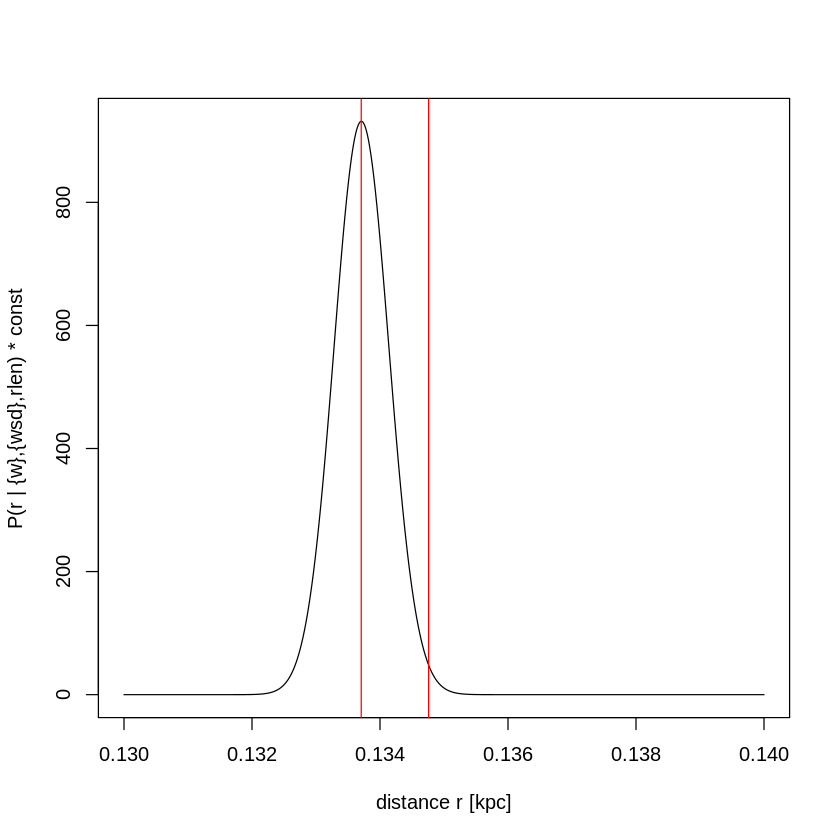

In [9]:
# Estimate the normalization constant, mean, and standard deviation of the posterior
# directly from the tabulation (using pdfmom)
mom <- pdfmom(dense, r)
cat("Posterior mean, SD for rc =", mom$mean, mom$sd, "kpc\n")
plot(r, dense/mom$Z, type="l", xlab="distance r [kpc]", ylab="P(r | {w},{wsd},rlen) * const")
abline(v=c(rNaive1, rNaive2), col="red")
# Note that in this case the mode is very close to rNaive2, because the data are highly 
# informative compared to the prior, so the maximum of the posterior is very 
# close to the maximum of the likelihood. The prior will only have a visible impact on
# the posterior once rlen ~ 0.001 or so.

# Estimate distance to cluster (with correlations, no cluster spread)

## Invent a simple model for spatial parallax correlations

I now allow for correlations between the parallaxes. Given a set of $N$ parallax measurements, their correlations are determined by the $N \times N$ covariance matrix $C$. The likelihood for the $N$ measurements is no longer a product of $N$ one-dimensional Gaussian functions, but is rather an $N$-dimensional Gaussian

$
P({\boldsymbol \varpi} | {\mathbf r}, C) = \frac{1}{(2\pi)^{N/2}|C|^{1/2}}\exp\left[-\frac{1}{2}\left({\boldsymbol \varpi} - \frac{1}{{\mathbf r}}\right)^\mathsf{T} C^{-1} \left({\boldsymbol \varpi} - \frac{1}{{\mathbf r}}\right)\right]
$

where

$
\frac{1}{{\mathbf r}} = \left(\frac{1}{r_1}, \frac{1}{r_2}, \ldots \right) .
$

To illustrate this approach I invent a model (unrelated to Gaia!) which specifies that the correlation between any two parallax measurements, $\varpi_1$ and $\varpi_2$, is a function of the angular separation, $\theta$, of the two sources on the sky

$
\rho(\varpi_1, \varpi_2) = a\exp(-\theta/\theta_{\rm len})
$


where $\theta_{\rm len}>0$ is some fixed angular scale and $0\leq a \leq 1$ gives the amplitude of the correlation at zero separation. The elements of the covariance matrix $C$ are 

$
C_{i,j} = \rho(\varpi_i, \varpi_j)\sigma_{\varpi_i}\sigma_{\varpi_j}.
$

Provided the two sources are not widely separated and not near the poles, we can approximate their angular separation as

$
\theta = \left( [(\alpha_1\!-\!\alpha_2)\cos(0.5(\delta_1\!+\!\delta_2))]^2 + (\delta_1\!-\!\delta_2)^2  \right)^{1/2}
$

where $(\alpha, \delta)$ are the RA and declination of a source.

In the code that follows, the function parcor computes $\rho$, and parcovmat computes $C$.

In [10]:
# The following R functions implement the above.
# Function parcor computes correlations between parallaxes for sources according to
# amp*exp(-sep/len), where sep is the angular separation on the sky of two sources,
# len is the length scale (sep and len have same units), and 0<=amp<=1.
parcor(dat$ra[1], dat$dec[1], dat$ra[2], dat$dec[2], amp=0.5, len=0.5)
# Function parcovmat computes the covariance matrix for a given set of sources 
# and the parameters for parcor
(mat <- parcovmat(dat=dat[1:3,], amp=0.5, len=0.5))
# d.likemulti computes the density of an N-dimensional likelihood (i.e. for N sources) with
# specified covariance matrix (parcovmat). For independent parallaxes, use parcovmat=NULL.
d.likemulti(w=dat$parallax[1:3], r=0.12, wsd=dat$parallax_error[1:3], parcovmat=mat)

[1] 0.02761605

0.057828708,0.0025803245,0.0018530974
0.002580325,0.1509670341,0.0001667215
0.001853097,0.0001667215,0.3664019852


[1] 1.927643e-05

## Naive parallax combination (with correlations)

This would be equivalent to maximum likelihood, which is equal to maximum posterior with a uniform (non-truncated) prior. So we'll just skip this and get to the more general posterior solution. (The parallax combination method doesn't give a probability distribution. It just gives one estimator and a (symmetric) standard deviation.)

## Posterior distance estimate (with correlations)

In [11]:
rlen <- 1 # in kpc
# ud.distpost3multi accommodates parallax covariances when its argument parcovmat!=NULL
# Test the function: the following two numbers should be identical
ud.distpost3multi(r=0.120, w=dat$parallax[1:4], wsd=dat$parallax_error[1:4], rlen=rlen)
ud.distpost3multi(r=0.120, w=dat$parallax[1:4], wsd=dat$parallax_error[1:4], 
                  parcovmat=diag(dat$parallax_error[1:4]^2), rlen=rlen)

[1] 6.465014e-08

[1] 6.465014e-08

In [12]:
# Compute the covariance matrix
mat <- parcovmat(dat=dat, amp=0.5, len=0.5)

With    correlations: Posterior mean, SD for r = 0.1341392 0.0007135305 kpc
Without correlations: Posterior mean, SD for r = 0.1337133 0.0004282268 kpc


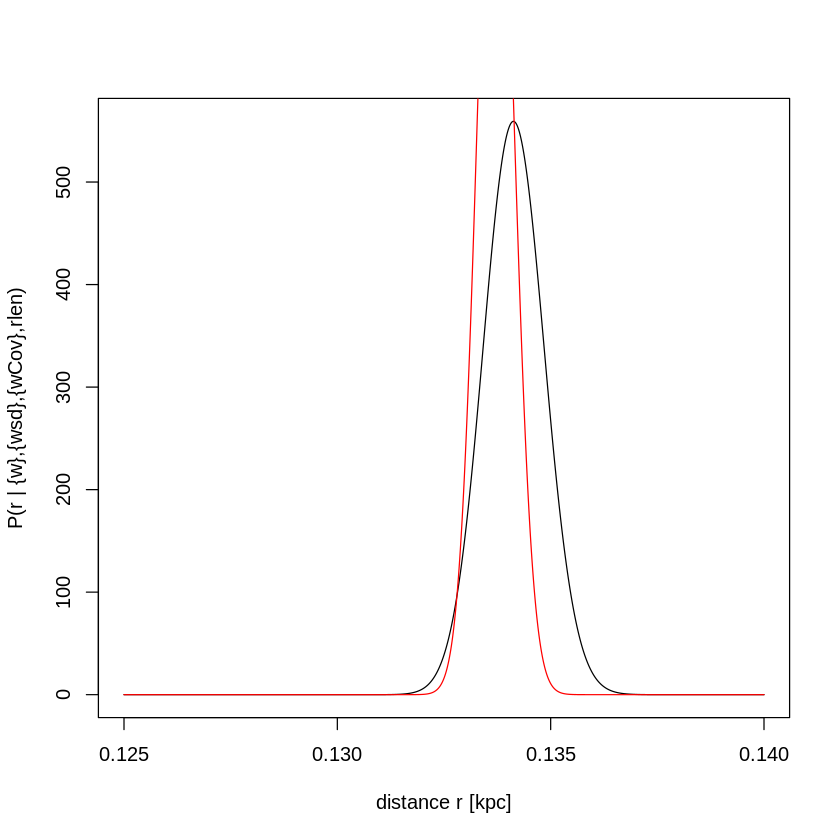

In [13]:
# Compute the posterior (scaled to have maximum=1) on a grid and plot (in black)
r <- seq(from=0.125, to=0.140, length.out=1e3)
#r <- seq(from=0.050, to=0.250, length.out=1e3) # to use with x20 uncertainties
dense <- ud.distpost3multi(r=r, w=dat$parallax, wsd=dat$parallax_error, parcovmat=mat, rlen=rlen)
mom <- pdfmom(dense, r)
cat("With    correlations: Posterior mean, SD for r =", mom$mean, mom$sd, "kpc\n")
plot(r, dense/mom$Z, type="l", xlab="distance r [kpc]", ylab="P(r | {w},{wsd},{wCov},rlen)")
# Overplot (in red) the posterior (obtained earlier) without correlations
dense <- ud.distpost3multi(r=r, w=dat$parallax, wsd=dat$parallax_error, rlen=rlen)
mom <- pdfmom(dense, r)
cat("Without correlations: Posterior mean, SD for r =", mom$mean, mom$sd, "kpc\n")
lines(r, dense/mom$Z, col="red")

# Estimate cluster distance and size (no correlations)

Reference document: [Cluster distance inference](resources/cluster_inference.pdf)

We now assume tht the cluster has a finite size, such that the true (unknown) distances to the members cannot be assumed to be equal. We want to compute the posterior 

$P^*(r_c,s_c|\{\varpi\},\{\sigma_{\varpi}\})$

where $r_c$ and $s_c$ are cluster distance and size respectively. The cluster center in (RA, Dec) is assumed known. For the sake of illustration I assume the true stellar distances are drawn from a 3D isotropic Gaussian of mean rc and standard deviation sc. (This is not a very good cluster model in reality. You could easily modify the code to use a different isotropic cluster distribution.) 

As shown in the reference document, the likelihood in the much more general case is a marginalization over the N unknown distances, i.e. an N-dimensional integral (equation 10)

$
P(\{\varpi\} | C, \{{\boldsymbol \alpha}\}, r_c, {\boldsymbol s}) = 
   \int P(\{\varpi\} | \{r\}, C) \, P(\{r\}| \{{\boldsymbol \alpha}\}, r_c, {\boldsymbol s})  \, d\{r\} 
$

where $P(\{\varpi\} | \{r\}, C)$ is the likelihood (multivariate Gaussian). The other term reflects the geometry of the cluster stars, which is given by equation 15. Here I neglect any correlations between the parallax measurements to reduce the likelihood to a product of N one-dimensional integrals. In that case the likelihood can be written as given in equation 17. (Note that that equation does not yet assume the Gaussian or even isotropic model for the cluster.)

We can now proceed in three different ways to deal with the likelihood.
1. Nelgect the *angular* extent of the cluster, but not its finite depth. We can then assume that the true distances of the stars from the cluster center (z) are along the l.o.s, and thus drawn from a 1D Gaussian with mean 0 and stdev sc. The resulting integral has no analytic solution. This can be made tractable - solution in form of an error function - using a binomial approximation of $\varpi-1/r$ with $r=r_c+x$ (where $x$ is the distance of the star from the centre of the cluster). This is done by the R function d.likecluster1 in distance_function.R, but the binomial approximation is poor, so this is not demonstrated below.
2. As 1, but now using a numerical integration (Gaussian quadrature) of the likelihood (instead of the binomial approximation). This is done by the R function d.listcluster2, with argument costheta=NULL, and is demonstrated below. This is given by equation 20 in the reference document.
3. Assume the cluster has a spherical Gaussian profile. For this we must specify the angular separations of the stars from the cluster centre, costheta. The integrals are done numerically (Gaussian quadrature). Sometimes the integrals don't converge (presumably due to limitations of the R function "integrate"), so for those specific cases (given star and rc,sc values) I revert to case 2 (for which there is no justification other than that's robust). This can also be done by d.likecluster2 by passing values for costheta, but it currently doesn't work too well so is not demonstrated below.

Our model has two parameters, the cluster distance, rc, and cluster size, sc. I use separable priors. For rc I again use the exponential decreasing space density prior. For sc I use a gamma distribution (appropriate, because it is zero for negative sizes). I compute the posterior on a regular 2D grid.

## The cluster size and distance prior

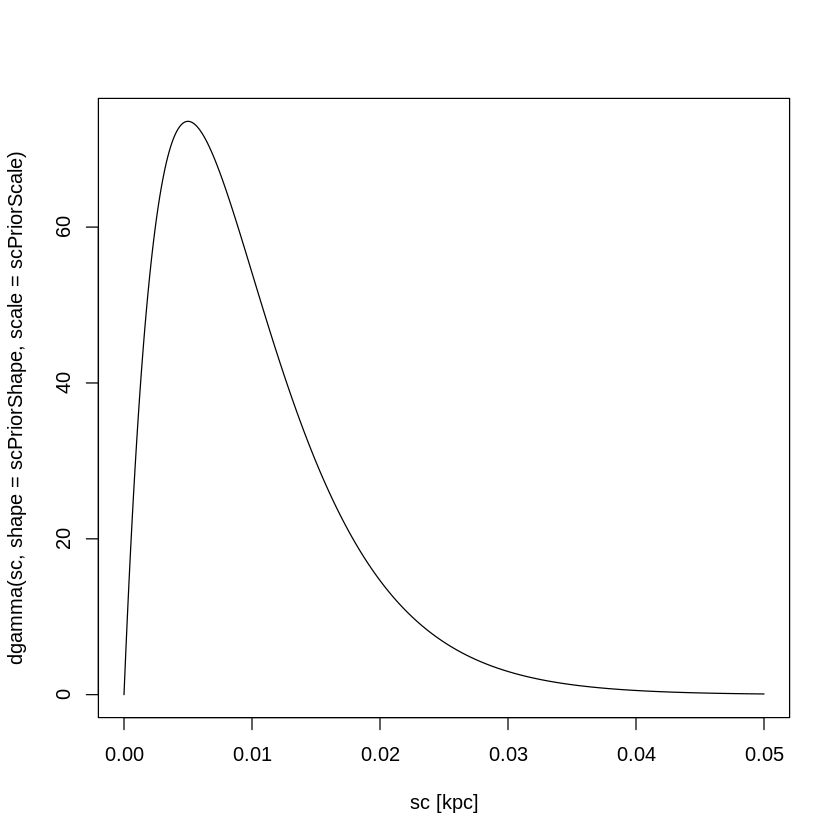

In [14]:
# I use the following gamma distribution as a prior on the cluster size, sc.
sc <- seq(from=0, to=0.050, length.out=1e3)
scPriorShape <- 2
scPriorScale <- 0.005
# Plot this prior
plot(sc, dgamma(sc, shape=scPriorShape, scale=scPriorScale), type="l", xlab="sc [kpc]")
# Set parameter for the exponential decreasing space density prior
rlen <- 1 # in kpc

### Test of likelihood using simulated data (Careful! This overwrites the table "dat")

You can use the following block of data to generate simulated data in order to test the likelihood for cases 1 and 2. But be aware that it overwrite the GDR1 data stored in dat

In [15]:
# True cluster is 1D along the l.o.s, so strictly theta=0 for all of them.
# We cannot expect results with case 3 to be good, as that assumes a spherical cluster.
set.seed(12345)
rcTrue <- 0.120
scTrue <- 0.01
Nstar <-  25
rTrue <- rnorm(n=Nstar,mean=rcTrue,sd=scTrue)
wsd <- rep.int(x=0.3,times=Nstar) 
w <- rnorm(n=Nstar,mean=1/rTrue,sd=wsd) # generates one random variable for each row of cbind(w,wsd)
dat <- data.frame(parallax=w, parallax_error=wsd)
dat[1:10,]

parallax,parallax_error
8.487163,0.3
7.723657,0.3
8.596050,0.3
8.844268,0.3
7.884108,0.3
10.064773,0.3
8.576645,0.3
9.144403,0.3
9.025186,0.3
9.101000,0.3


## Compute posterior using case 2 (1D approximation of cluster geometry, numerical integrations)

In [15]:
# We evaluate the 2D posterior on the following regular grid.
# This takes about 2.5 minutes on my laptop using gdr1set03.csv (164 stars), 
# so you might want to test it first using 10 simulated stars (see code for this above).
rc <- seq(from=0.120, to=0.140, length.out=100)
sc <- seq(from=0.0001, to=0.030, length.out=100)
lndense <- matrix(0, nrow=length(rc), ncol=length(sc))
cat("Of", length(sc), "outer loop steps, no. remaining:\n")
for(j in 1:length(sc)) {
  cat(j," ")
  for(i in 1:length(rc)) {
    lndense[i,j] <- d.likecluster2(w=dat$parallax, wsd=dat$parallax_error, rc=rc[i], sc=sc[j], retlog=TRUE) +
      log(d.distprior3(r=rc[i], rlen=rlen)) + dgamma(x=sc[j], shape=scPriorShape, scale=scPriorScale, log=TRUE)   
  }
}
cat("\n")

Of 100 outer loop steps, no. remaining:
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  


Posterior mean, SD for sc = 0.01316349 0.0009870501 kpc
Posterior mean, SD for rc = 0.1356696 0.001145217 kpc


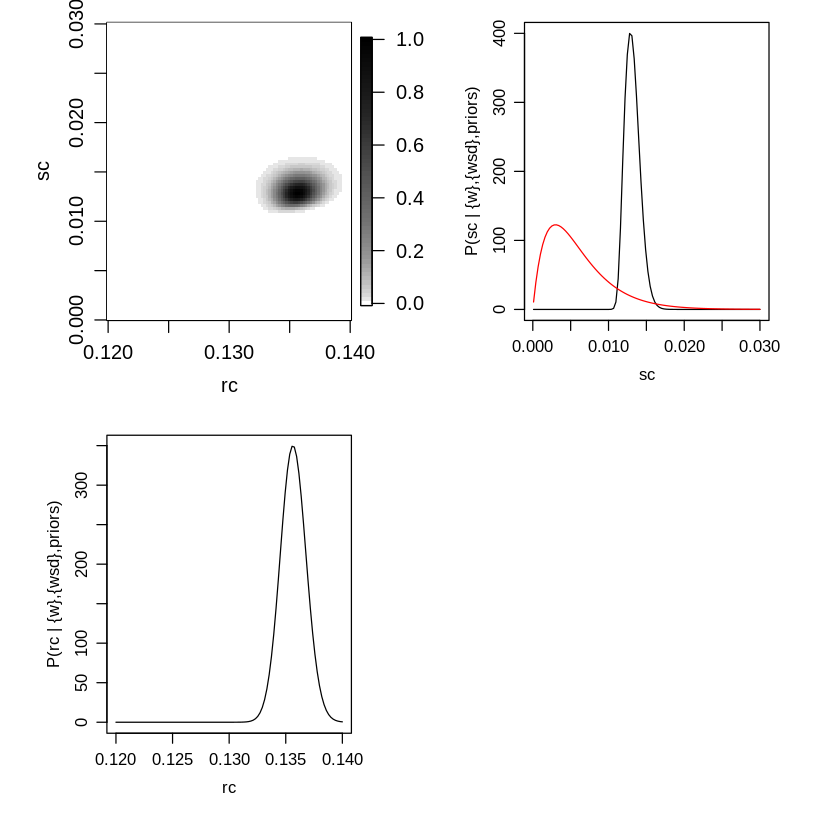

In [16]:
# Plot the unnormalized 2D posterior on a grey scale (maximum set to 1)
# as well as the two marginal PDFs (which is achieved simply by summing the grid, 
# as it's regular) which I normalize.
dense <- exp(lndense - max(lndense))
par(mfrow=c(2,2), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
image.plot(z=dense, x=rc, y=sc, nlevel=1024, col=mycols)
scDense <- apply(dense, 2, sum)
mom <- pdfmom(scDense, sc)
cat("Posterior mean, SD for sc =", mom$mean, mom$sd, "kpc\n")
plot(sc, scDense/mom$Z, type="l", ylab="P(sc | {w},{wsd},priors)")
lines(sc, dgamma(sc, shape=2, scale=0.003), col="red") # overplot prior on sc in red
rcDense <- apply(dense, 1, sum)
mom <- pdfmom(rcDense, rc)
cat("Posterior mean, SD for rc =", mom$mean, mom$sd, "kpc\n")
plot(rc, rcDense/mom$Z, type="l", ylab="P(rc | {w},{wsd},priors)")
# compare result with parallaxes (!) derived in GDR1 overview and cluster papers

## Compute posterior using case 3 (3D Gaussian cluster)
If you want to try this, you need to specify the cluster centre and then comupte the angular separations of the stars from this centre. This is done below. You then need to pass to d.likecluster2 the additional parameter costheta=cos(theta*pi/180). However, this does not work too well at present.

In [17]:
clustCen <- data.frame(ra=56.75, dec=24.12) # RA, Dec of cluster center in degrees
theta <- sqrt(((dat$ra-clustCen$ra)*cos(conv*clustCen$dec))^2 +
                (dat$dec-clustCen$dec)^2) # on-sky separations from clustCen in degrees